In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, platform, os
import camb
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import math
import mpl_toolkits.axes_grid1 as axgrid
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.optimize
plt.rcParams['mathtext.fontset'], plt.rcParams['font.family'] = 'stix', 'STIXGeneral'
plt.rcParams.update({'font.size': 17})

In [49]:
from scipy.optimize import least_squares, nnls, lsq_linear

# Nonlinear least squares

## 1.) scipy.optimize.least_squares

### Creating "fake" observational data

In [2]:
pars_test = camb.set_params(H0=67.5, 
                            ombh2=0.022, 
                            omch2=0.120*1.2, 
                            redshifts=[0], 
                            kmax=10, 
                            As=2e-9, 
                            ns=0.96, 
                            halofit_version='mead2020_feedback', 
                            HMCode_A_baryon = 0, 
                            HMCode_eta_baryon = 0, 
                            HMCode_logT_AGN = -10)
                            # zero the HMCode to get a universe without baryonic feedback
results_test = camb.get_transfer_functions(pars_test)
kh_test, _, pk_test = results_test.get_nonlinear_matter_power_spectrum(hubble_units=True, k_hunit=True)

kh_data = kh_test
pk_data = pk_test[0]

### Creating cosmology based on Planck2018 for reference

In [3]:
pars_planck_2018 = camb.set_params(H0=67.4, ombh2=0.0224, omch2=0.120,
                                  redshifts=[0], kmax=10, As=2e-9, ns=0.96, 
                                  halofit_version='mead2020_feedback',
                                  HMCode_A_baryon=0, HMCode_eta_baryon=0, HMCode_logT_AGN=-10)
results_planck_2018 = camb.get_transfer_functions(pars_planck_2018)
kh_planck2018, _, pk_planck2018 = results_planck_2018.get_nonlinear_matter_power_spectrum(hubble_units=True, k_hunit=True)

### Creating baryonic feedback models, one with 'mead', another with 'mead2020_feedback' (piecing method will be used)

In [16]:
def baryon_feedback(x_data, baryons):
    pars = camb.set_params(H0=67.5, ombh2=0.022, omch2=0.122, redshifts=[0], kmax=10, As=2e-9, ns=0.96, 
                           halofit_version='mead2020_feedback', 
                           HMCode_A_baryon = baryons[0], 
                           HMCode_eta_baryon = baryons[1], 
                           HMCode_logT_AGN = baryons[2])
    results = camb.get_transfer_functions(pars)
    kh, _ , pk = results.get_nonlinear_matter_power_spectrum(hubble_units=True, k_hunit=True)
    return pk[0]

def baryon_mead(x_data, baryons):
    pars = camb.set_params(H0=67.5, ombh2=0.022, omch2=0.122, redshifts=[0], kmax=10, As=2e-9, ns=0.96, 
                           halofit_version='mead', 
                           HMCode_A_baryon = baryons[0], 
                           HMCode_eta_baryon = baryons[1], 
                           HMCode_logT_AGN = baryons[2])
    results = camb.get_transfer_functions(pars)
    kh, _ , pk = results.get_nonlinear_matter_power_spectrum(hubble_units=True, k_hunit=True)
    return pk[0]

In [17]:
def residuals_feedback(baryons, y_data, x_data):
    return y_data - baryon_feedback(x_data, baryons)

def residuals_mead(baryons, y_data, x_data):
    return y_data - baryon_mead(x_data, baryons)

In [85]:
guesses = np.array([3.13, 0.603, 7.8])

best_fit_mead = least_squares(residuals_mead, guesses, args=(pk_data, kh_data))
print('Mead: ', best_fit_mead.x)

Mead:  [ 4.03317277 -0.38541268  7.8       ]


In [86]:
best_fit_feedback = least_squares(residuals_feedback, guesses, args=(pk_data, kh_data))
print('Mead2020_feedback: ', best_fit_feedback.x)

Mead2020_feedback:  [3.13       0.603      9.90651285]


In [88]:
best_fit_params = np.array([best_fit_mead.x[0], best_fit_mead.x[1], best_fit_feedback.x[2]])
print('Pieced together params: ', best_fit_params)

Pieced together params:  [ 4.03317277 -0.38541268  9.90651285]


In [89]:
params_by_eye = np.array([best_fit_params[0], best_fit_params[1], -10])
print('params by eye: ', params_by_eye) # kick the tail on small scales up by setting logT_AGN = 0

params by eye:  [  4.03317277  -0.38541268 -10.        ]


<Figure size 432x288 with 0 Axes>

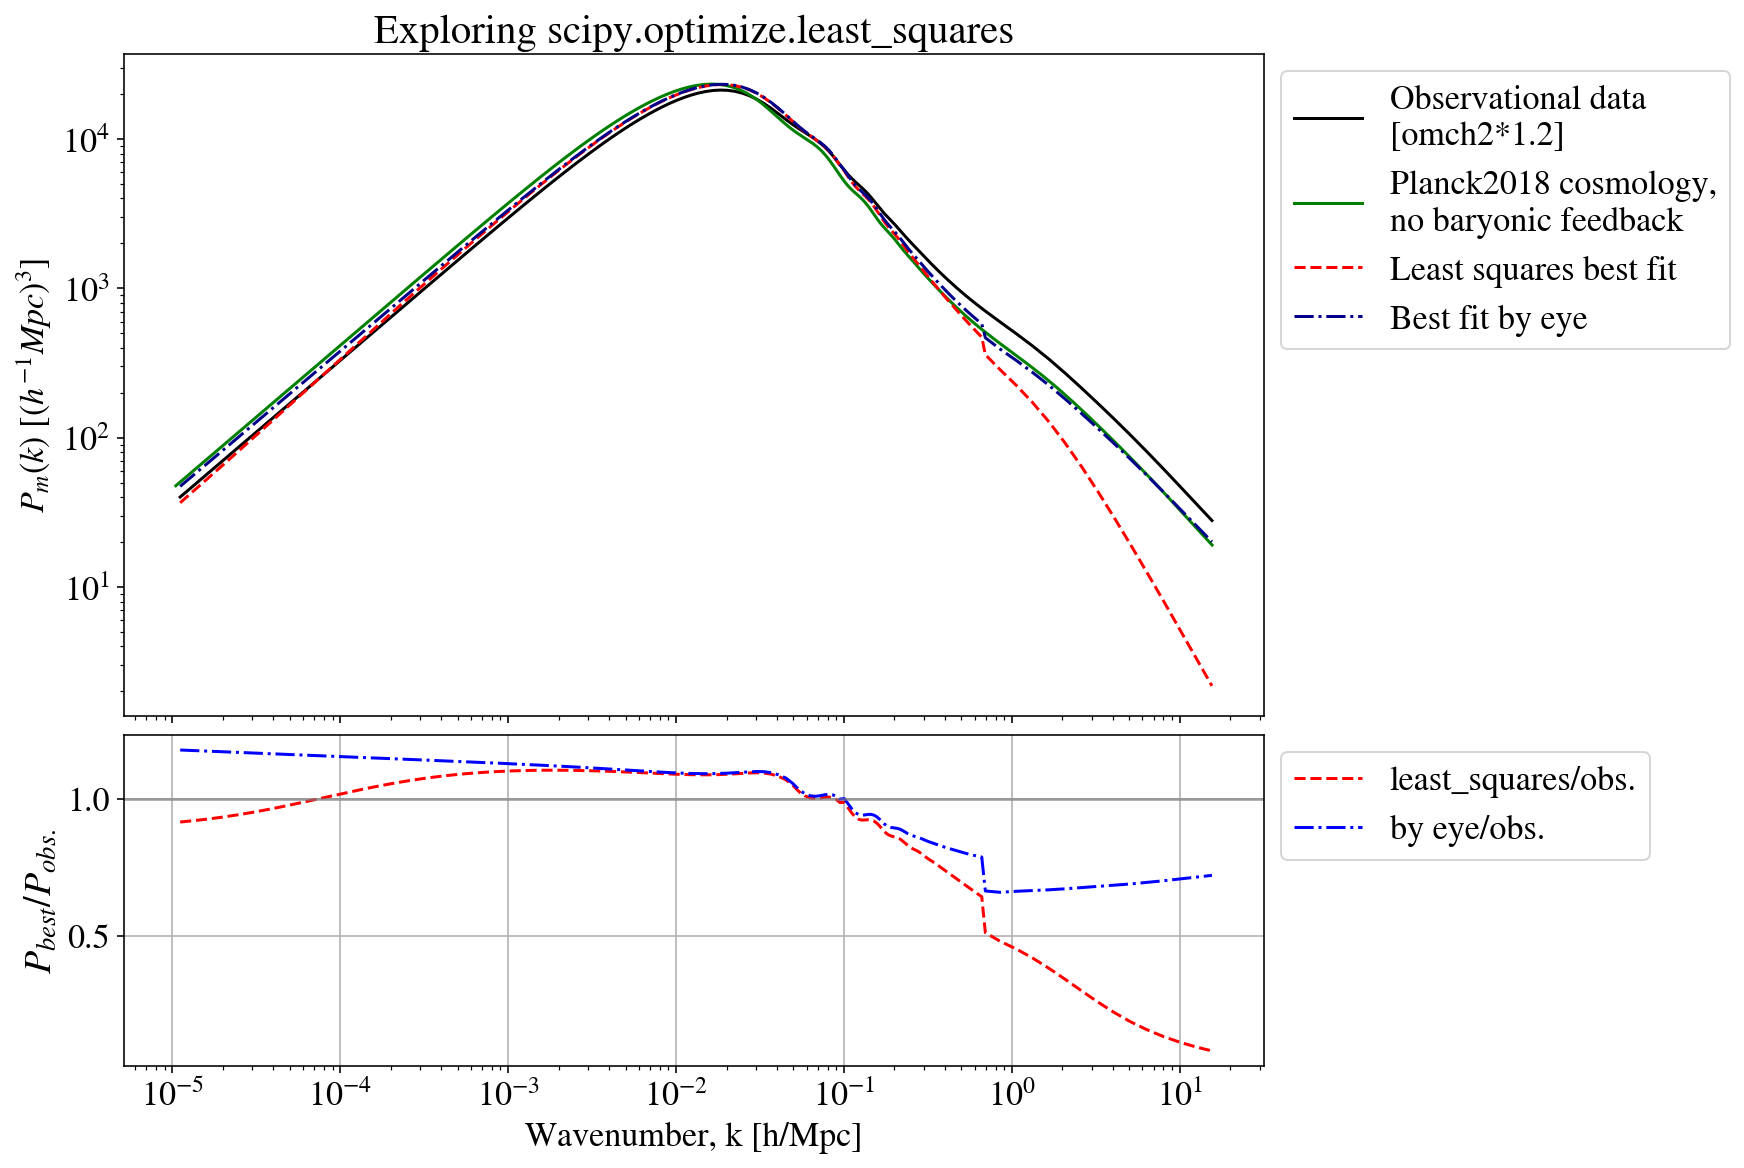

In [90]:
plt.figure()
fig, (ax0, ax1) = plt.subplots(ncols=1, nrows=2, 
                               figsize=(12,8), 
                               constrained_layout=True, 
                               sharex=True, 
                               gridspec_kw={'height_ratios':[3, 1.5]})
#fig.suptitle('Attemping to fit by eye')

ax0.loglog(kh_data, pk_data, 'k-', label='Observational data\n[omch2*1.2]')
ax0.loglog(kh_planck2018, pk_planck2018[0], 'g-', label='Planck2018 cosmology,\nno baryonic feedback')
ax0.loglog(kh_data, baryon_feedback(kh_data, best_fit_params), 'r', linestyle='--', label='Least squares best fit')
ax0.loglog(kh_data, baryon_feedback(kh_data, params_by_eye), 'darkblue', linestyle='-.', label='Best fit by eye')

ax0.set_title('Exploring scipy.optimize.least_squares')
ax0.set_ylabel('$P_m(k)$ [($h^{-1}Mpc)^3$]')
ax0.legend(bbox_to_anchor = (1, 1), loc='upper left')
#props = dict(boxstyle='round', facecolor='white')
#ax0.text(0.00001, 5000, 'Best fit parameters:\nA = 3.13\neta = 0.603\nlogT_AGN = -10')


ax1.semilogx(kh_data, baryon_feedback(kh_data, best_fit_params)/pk_data, color='r', linestyle='--', label='least_squares/obs.')
ax1.semilogx(kh_data, baryon_feedback(kh_data, params_by_eye)/pk_data, color='b', linestyle='-.', label='by eye/obs.')
#ax1.semilogx(kh_data, baryon_feedback(kh_data, defaults_plus_eye)/pk_data, color='c', linestyle=':')
ax1.legend(bbox_to_anchor = (1, 1), loc='upper left')
ax1.axhline(1, color='grey', alpha=0.6)
ax1.set_ylabel('$P_{best}/P_{obs.}$', fontsize=19)
ax1.set_xlabel('Wavenumber, k [h/Mpc]')
ax1.grid()
plt.show()



# Linear least squares

## 2.) scipy.optimize.nnls()

## 3.) scipy.optimize.lsq_linear()

In [82]:
pk_data_reshaped = np.reshape(pk_data, (len(pk_data),1))
pk_data_reshaped.shape

guesses_reshaped = np.reshape(guesses, (1,3))
residuals_reshaped = np.reshape(residuals_mead(guesses, pk_data, kh_data), (1,len(residuals_mead(guesses, pk_data, kh_data))))

lsq_linear(guesses_reshaped, residuals_reshaped)


ValueError: `b` must have at most 1 dimension.